In [3]:
#Loading Libraries

import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from PIL import Image 

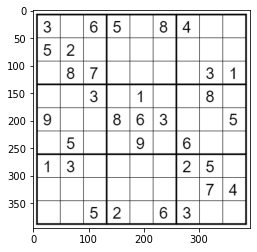

In [4]:
file_path = 'media/images/sudoku-grid.png'
img = cv2.imread(file_path)
plt.imshow(img)

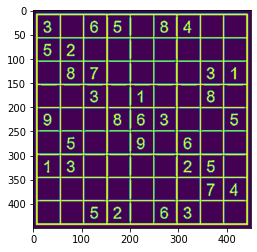

In [5]:
#Preprocessing image to be read
sudoku_a = cv2.resize(img, (450,450))

# function to greyscale, blur and change the receptive threshold of image
def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    blur = cv2.GaussianBlur(gray, (3,3),6) 
    #blur = cv2.bilateralFilter(gray,9,75,75)
    threshold_img = cv2.adaptiveThreshold(blur,255,1,1,11,2)
    return threshold_img

threshold = preprocess(sudoku_a)

#let's look at what we have got
plt.figure()
plt.imshow(threshold)
plt.show()

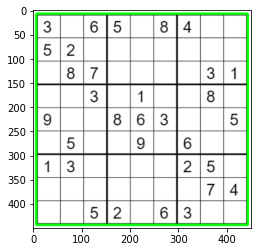

In [6]:
contour_1 = sudoku_a.copy()
contour_2 = sudoku_a.copy()
contour, hierarchy = cv2.findContours(threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_1, contour,-1,(0,255,0),3)

#let's see what we got
plt.figure()
plt.imshow(contour_1)
plt.show()

In [7]:
def main_outline(contour):
    biggest = np.array([])
    max_area = 0
    for i in contour:
        area = cv2.contourArea(i)
        if area >50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i , 0.02* peri, True)
            if area > max_area and len(approx) ==4:
                biggest = approx
                max_area = area
    return biggest ,max_area

In [8]:
def reframe(points):
    points = points.reshape((4, 2))
    points_new = np.zeros((4,1,2),dtype = np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] = points[np.argmax(add)]
    diff = np.diff(points, axis =1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

In [9]:
def splitcells(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

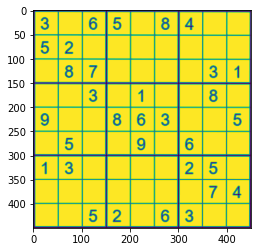

In [10]:
black_img = np.zeros((450,450,3), np.uint8)
biggest, maxArea = main_outline(contour)
if biggest.size != 0:
    biggest = reframe(biggest)
    cv2.drawContours(contour_2,biggest,-1, (0,255,0),10)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[450,0],[0,450],[450,450]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)  
    imagewrap = cv2.warpPerspective(sudoku_a,matrix,(450,450))
    imagewrap =cv2.cvtColor(imagewrap, cv2.COLOR_BGR2GRAY)
    
plt.figure()
plt.imshow(imagewrap)
plt.show()

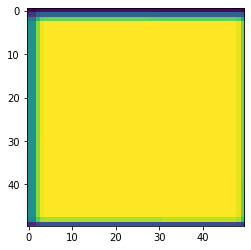

In [11]:
sudoku_cell = splitcells(imagewrap)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell[58])
plt.show()

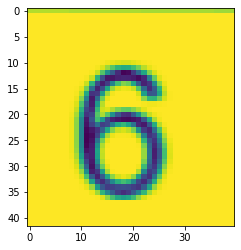

In [12]:
def CropCell(cells):
    Cells_croped = []
    for image in cells:
        
        img = np.array(image)
        img = img[4:46, 6:46]
        img = Image.fromarray(img)
        Cells_croped.append(img)
        
    return Cells_croped

sudoku_cell_croped= CropCell(sudoku_cell)
#Let's have alook at the last cell
plt.figure()
plt.imshow(sudoku_cell_croped[2])
plt.show()

# OCR

In [14]:
#Loading the data 

data = os.listdir(r"static/dataset/Digits" )
data_X = []     
data_y = []  
data_classes = len(data)
for i in range (0,data_classes):
    data_list = os.listdir(r"static/dataset/Digits" +"/"+str(i))
    for j in data_list:
        pic = cv2.imread(r"static/dataset/Digits" +"/"+str(i)+"/"+j)
        pic = cv2.resize(pic,(32,32))
        data_X.append(pic)
        data_y.append(i)

         
if len(data_X) == len(data_y) :
    print("Total Dataponits = ",len(data_X))

# Labels and images
data_X = np.array(data_X)
data_y = np.array(data_y)

Total Dataponits =  10160


In [15]:
#Spliting the train validation and test sets

train_X, test_X, train_y, test_y = train_test_split(data_X,data_y,test_size=0.05)
train_X, valid_X, train_y, valid_y = train_test_split(train_X,train_y,test_size=0.2)
print("Training Set Shape = ",train_X.shape)
print("Validation Set Shape = ",valid_X.shape)
print("Test Set Shape = ",test_X.shape)

Training Set Shape =  (7721, 32, 32, 3)
Validation Set Shape =  (1931, 32, 32, 3)
Test Set Shape =  (508, 32, 32, 3)


In [16]:
# Preprocessing the images for neuralnet

def Prep(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #making image grayscale
    img = cv2.equalizeHist(img) #Histogram equalization to enhance contrast
    img = img/255 #normalizing
    return img

train_X = np.array(list(map(Prep, train_X)))
test_X = np.array(list(map(Prep, test_X)))
valid_X= np.array(list(map(Prep, valid_X)))

#Reshaping the images
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2],1)
valid_X = valid_X.reshape(valid_X.shape[0], valid_X.shape[1], valid_X.shape[2],1)

#Augmentation
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1, rotation_range=10)
datagen.fit(train_X)

In [17]:
# One hot encoding of the labels

train_y = to_categorical(train_y, data_classes)
test_y = to_categorical(test_y, data_classes)
valid_y = to_categorical(valid_y, data_classes)

In [18]:
#Creating a Neural Network

model = Sequential()

model.add((Conv2D(60,(5,5),input_shape=(32, 32, 1) ,padding = 'Same' ,activation='relu')))
model.add((Conv2D(60, (5,5),padding="same",activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))

model.add((Conv2D(30, (3,3),padding="same", activation='relu')))
model.add((Conv2D(30, (3,3), padding="same", activation='relu')))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(500,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 30)        8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 30)         0         
 2D)                                                    

In [24]:
#Compiling the model

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon = 1e-08, decay=0.0)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

#Fit the model

history = model.fit(datagen.flow(train_X, train_y, batch_size=32),
                              epochs = 10, validation_data = (valid_X, valid_y),
                              verbose = 2, steps_per_epoch= 200)

Epoch 1/10
200/200 - 88s - loss: 0.0863 - accuracy: 0.9779 - val_loss: 0.0183 - val_accuracy: 0.9938 - 88s/epoch - 439ms/step
Epoch 2/10
200/200 - 85s - loss: 0.0762 - accuracy: 0.9822 - val_loss: 0.0453 - val_accuracy: 0.9881 - 85s/epoch - 426ms/step
Epoch 3/10
200/200 - 75s - loss: 0.0726 - accuracy: 0.9804 - val_loss: 0.0117 - val_accuracy: 0.9964 - 75s/epoch - 375ms/step
Epoch 4/10
200/200 - 70s - loss: 0.0793 - accuracy: 0.9804 - val_loss: 0.0249 - val_accuracy: 0.9933 - 70s/epoch - 352ms/step
Epoch 5/10
200/200 - 68s - loss: 0.0723 - accuracy: 0.9817 - val_loss: 0.0083 - val_accuracy: 0.9974 - 68s/epoch - 342ms/step
Epoch 6/10
200/200 - 68s - loss: 0.0771 - accuracy: 0.9788 - val_loss: 0.0083 - val_accuracy: 0.9974 - 68s/epoch - 341ms/step
Epoch 7/10
200/200 - 68s - loss: 0.0638 - accuracy: 0.9831 - val_loss: 0.0194 - val_accuracy: 0.9933 - 68s/epoch - 342ms/step
Epoch 8/10
200/200 - 68s - loss: 0.0697 - accuracy: 0.9821 - val_loss: 0.0302 - val_accuracy: 0.9907 - 68s/epoch - 339

In [21]:
# Testing the model on the test set

score = model.evaluate(test_X, test_y, verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.02293243072926998
Test Accuracy = 0.9921259880065918


In [22]:
def read_cells(cell,model):

    result = []
    for image in cell:
        # preprocess the image as it was in the model 
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] -4]
        img = cv2.resize(img, (32, 32))
        img = img / 255
        img = img.reshape(1, 32, 32, 1)
        # getting predictions and setting the values if probabilities are above 65% 
        
        predictions = model.predict(img)
        classIndex = np.argmax(predictions, axis=1)
        probabilityValue = np.amax(predictions)
        
        if probabilityValue > 0.65:
            result.append(classIndex[0])
        else:
            result.append(0)
    return result

grid = read_cells(sudoku_cell_croped, model)
grid = np.asarray(grid)

In [23]:
matrix = np.reshape(grid, (9,9))
matrix

array([[0, 3, 7, 0, 6, 8, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 8, 0, 7],
       [0, 8, 0, 0, 0, 0, 0, 6, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [8, 0, 0, 0, 0, 0, 6, 0, 9],
       [0, 0, 0, 6, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 9, 0],
       [7, 0, 0, 0, 0, 6, 0, 0, 0],
       [0, 0, 0, 9, 8, 0, 0, 5, 6]], dtype=int64)

In [ ]:
matrix[8][0] = 0
matrix[6][1] = 1
print(matrix)

In [ ]:
def find_empty_location(arr, l):
    for row in range(9):
        for col in range(9):
            if(arr[row][col]== 0):
                l[0]= row
                l[1]= col
                return True
    return False

In [ ]:
def used_in_row(arr, row, num):
    for i in range(9):
        if(arr[row][i] == num):
            return True
    return False

def used_in_col(arr, col, num):
    for i in range(9):
        if(arr[i][col] == num):
            return True
    return False

def used_in_box(arr, row, col, num):
    for i in range(3):
        for j in range(3):
            if(arr[i + row][j + col] == num):
                return True
    return False

In [ ]:
def check_location_is_safe(arr, row, col, num):
     
    # Check if 'num' is not already
    # placed in current row,
    # current column and current 3x3 box
    return not used_in_row(arr, row, num) and not used_in_col(arr, col, num) and not used_in_box(arr, row - row % 3, col - col % 3, num)

In [ ]:
def solve_sudoku(arr):
     
    # 'l' is a list variable that keeps the
    # record of row and col in
    # find_empty_location Function   
    l =[0, 0]
     
    # If there is no unassigned
    # location, we are done   
    if(not find_empty_location(arr, l)):
        return True
     
    # Assigning list values to row and col
    # that we got from the above Function
    row = l[0]
    col = l[1]
     
    # consider digits 1 to 9
    for num in range(1, 10):
         
        # if looks promising
        if(check_location_is_safe(arr,
                          row, col, num)):
             
            # make tentative assignment
            arr[row][col]= num
 
            # return, if success,
            # ya !
            if(solve_sudoku(arr)):
                return True
 
            # failure, unmake & try again
            arr[row][col] = 0
             
    # this triggers backtracking       
    return False

In [ ]:
solve_sudoku(matrix)

In [ ]:
print(matrix)